In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
df = pd.read_csv('C:/Users/user/github/Data/energy/train.csv', encoding='cp949')

In [3]:
eda_df = df.copy()

In [4]:
eda_df['month'] = 0
eda_df['hour'] = 0
eda_df['year'] = 0
eda_df['day'] = 0
eda_df['요일'] = 0

In [5]:
eda_df.date_time = pd.to_datetime(eda_df.date_time)

In [6]:
days = {0: '월요일', 1: '화요일', 2: '수요일', 3: '목요일', 4: '금요일', 5: '토요일', 6: '일요일'}

In [7]:
eda_df['month'] = eda_df.date_time.dt.month
eda_df['hour'] = eda_df.date_time.dt.hour
eda_df['year'] = eda_df.date_time.dt.year
eda_df['day'] = eda_df.date_time.dt.day
eda_df['요일'] = eda_df['date_time'].dt.weekday.map(days)

In [8]:
input = eda_df.drop(['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','month'], axis=1)

In [9]:
mean = pd.DataFrame(input.groupby(['num','요일','hour']).mean()['전력사용량(kWh)'])

In [10]:
std = pd.DataFrame(input.groupby(['num','요일','hour']).std()['전력사용량(kWh)'])

In [11]:
total_df = pd.merge(mean, std, how='inner', left_on = ['num','요일','hour'], right_on=['num','요일','hour'])

In [12]:
total_df.reset_index(inplace=True)

In [13]:
total_df.columns = ['num' ,'요일', 'hour', 'mean', 'std']

In [14]:
class HourlyDataUpdater:
    def __init__(self, hourly_means, hourly_std_devs, alpha=0.1):
        self.hourly_means = hourly_means
        self.hourly_std_devs = hourly_std_devs
        self.alpha = alpha

    def update(self, hour, new_data):
        old_mean = self.hourly_means[hour]
        old_std_dev = self.hourly_std_devs[hour]

        # 평균 업데이트
        new_mean = old_mean * (1 - self.alpha) + new_data * self.alpha

        # 표준편차 업데이트
        new_std_dev = np.sqrt((1 - self.alpha) * (old_std_dev ** 2) + self.alpha * ((new_data - old_mean) ** 2))

        # 값 업데이트
        self.hourly_means[hour] = new_mean
        self.hourly_std_devs[hour] = new_std_dev

        return new_mean

    def predict(self, hour, new_data):
        updated_mean = self.update(hour, new_data)
        return stats.norm(updated_mean, self.hourly_std_devs[hour]).pdf(new_data)

In [15]:
def get_weekday_indices(index):
    datetime_index = pd.DatetimeIndex(index)
    weekday_indices = datetime_index[datetime_index.weekday < 5]
    return weekday_indices

In [16]:
df_1 = df[df['num']==1]

In [17]:
df_1.date_time = pd.to_datetime(df_1.date_time)

In [18]:
df_1 = df_1.set_index(['date_time'])

In [19]:
weekday = get_weekday_indices(df_1.index)

In [20]:
weekday

DatetimeIndex(['2020-06-01 00:00:00', '2020-06-01 01:00:00',
               '2020-06-01 02:00:00', '2020-06-01 03:00:00',
               '2020-06-01 04:00:00', '2020-06-01 05:00:00',
               '2020-06-01 06:00:00', '2020-06-01 07:00:00',
               '2020-06-01 08:00:00', '2020-06-01 09:00:00',
               ...
               '2020-08-24 14:00:00', '2020-08-24 15:00:00',
               '2020-08-24 16:00:00', '2020-08-24 17:00:00',
               '2020-08-24 18:00:00', '2020-08-24 19:00:00',
               '2020-08-24 20:00:00', '2020-08-24 21:00:00',
               '2020-08-24 22:00:00', '2020-08-24 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=1464, freq=None)

In [21]:
input_1 = df_1.loc[weekday]

In [22]:
input_1.reset_index(inplace=True)

In [23]:
input_1['hour'] = input_1.date_time.dt.hour

In [24]:
input_1

,date_time,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,hour
0,2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1
2,2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-08-24 19:00:00,1,8714.952,29.4,3.4,66.0,0.0,0.2,0.0,0.0,19
1460,2020-08-24 20:00:00,1,8740.224,28.7,1.9,69.0,0.0,0.0,0.0,0.0,20
1461,2020-08-24 21:00:00,1,8730.504,28.3,1.1,71.0,0.0,0.0,0.0,0.0,21
1462,2020-08-24 22:00:00,1,8725.968,28.3,2.4,72.0,0.0,0.0,0.0,0.0,22


In [25]:
mean = input_1[:24*30].groupby(['hour']).mean()['전력사용량(kWh)']
std = input_1[:24*30].groupby(['hour']).std()['전력사용량(kWh)']

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [27]:
hourly_means = mean 
hourly_std_devs = std
total_means = []
pred_error_mse = []
pred_error_mae = []

for i in range(30):
    new_data = input_1.iloc[24 * i + 30 * 24 : 24 * (i+1) + 30 * 24, 2]

    updater = HourlyDataUpdater(hourly_means, hourly_std_devs, alpha=0.5)

    updated_means = []
    for hour, data in enumerate(new_data):
        updated_mean = updater.update(hour, data)
        updated_means.append(updated_mean)
    
    pred_error_mse.append(mean_squared_error(new_data, updated_means))
    pred_error_mae.append(mean_absolute_error(new_data, updated_means))
    
    total_means.append(updated_means)

In [28]:
mean_absolute_error(new_data, updated_means)

7.829654504012903

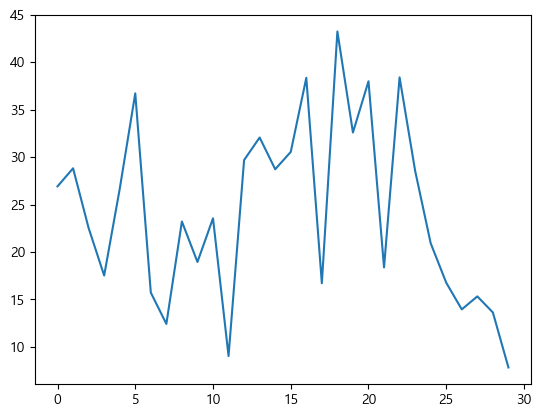

In [29]:
plt.plot(pred_error_mae)

In [30]:
train_data = input_1[:24*30].iloc[:,2]

In [31]:
test_data = input_1[24*30:].iloc[:,2]

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
input_1

,date_time,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,hour
0,2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1
2,2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-08-24 19:00:00,1,8714.952,29.4,3.4,66.0,0.0,0.2,0.0,0.0,19
1460,2020-08-24 20:00:00,1,8740.224,28.7,1.9,69.0,0.0,0.0,0.0,0.0,20
1461,2020-08-24 21:00:00,1,8730.504,28.3,1.1,71.0,0.0,0.0,0.0,0.0,21
1462,2020-08-24 22:00:00,1,8725.968,28.3,2.4,72.0,0.0,0.0,0.0,0.0,22


In [34]:
train_rf = input_1[:24*30][['date_time', '전력사용량(kWh)']]
test_rf = input_1[24*30:][['date_time', '전력사용량(kWh)']]

In [35]:
train_rf['hour'] = train_rf.date_time.dt.hour
train_rf['month'] = train_rf.date_time.dt.month
train_rf['dayofweek'] = train_rf.date_time.dt.dayofweek

test_rf['hour'] = test_rf.date_time.dt.hour
test_rf['month'] = test_rf.date_time.dt.month
test_rf['dayofweek'] = test_rf.date_time.dt.dayofweek

In [36]:
train_rf_x = train_rf[['hour', 'month', 'dayofweek']]
test_rf_x = test_rf[['hour', 'month', 'dayofweek']]

train_rf_y = train_rf['전력사용량(kWh)']
test_rf_y = test_rf['전력사용량(kWh)']

In [37]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [38]:
rf.fit(train_rf_x, train_rf_y)

RandomForestRegressor(random_state=42)

In [39]:
from pmdarima import auto_arima

In [40]:
auto_arima_model =  auto_arima(train_rf_y, seasonal=True, m=12, trace=True,
                   error_action='ignore', 
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7284.979, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7278.634, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7281.694, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7283.083, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7283.358, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=7214.470, Time=1.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=7238.002, Time=0.58 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=7216.466, Time=1.48 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=7216.467, Time=1.67 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=7215.842, Time=0.74 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=7218.435, Time=3.27 sec
 ARIMA(1,1,0)(2,0,0)[12]          

In [41]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(1, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -3602.252
Date:                            Mon, 28 Aug 2023   AIC                           7212.505
Time:                                    16:58:49   BIC                           7230.816
Sample:                                         0   HQIC                          7219.574
                                            - 720                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2009      0.009    -22.799      0.000      -0.218      -0.184
ar.S.L12      -0.0730      0.042     -1.747      0.081      -0.155       0.009
ar.S.L24       0.3185      0.014     23.588      0.000       0.292       0.345
sigma2      1310.7088     16.059     81.620      0.000    1279.234    1342.183
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             92055.06
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [55]:
model_mse = []
model_mae = []
model_mape = []

for i in range(30):
    new_data_x = input_1.iloc[: 24 * (i+1) + 30 * 24, :]
    new_data_y = input_1.iloc[: 24 * (i+1) + 30 * 24, 2]

    new_data_x['hour'] = new_data_x.date_time.dt.hour
    new_data_x['month'] = new_data_x.date_time.dt.month
    new_data_x['dayofweek'] = new_data_x.date_time.dt.dayofweek

    input_new_x = new_data_x[['hour', 'month', 'dayofweek']]

    auto_arima_model.fit(new_data_y)
    rf.fit(input_new_x ,new_data_y)

    # 베이지안 업데이트와 동일한 방식으로 테스트 데이터 세트 분리
    test_data_x = test_rf_x.iloc[24 * i: 24 * (i+1)]
    test_data_y = test_rf_y.iloc[24 * i: 24 * (i+1)]

    # 예측 수행
    predictions_rf = rf.predict(test_data_x)
    predictions_auto_arima = auto_arima_model.predict(n_periods=24)

    # 오차 계산
    mse_rf = mean_squared_error(test_data_y, predictions_rf)
    mae_rf = mean_absolute_error(test_data_y, predictions_rf)
    mape_rf = mean_absolute_percentage_error(test_data_y, predictions_rf)

    mse_auto_arima = mean_squared_error(test_data_y, predictions_auto_arima)
    mae_auto_arima = mean_absolute_error(test_data_y, predictions_auto_arima)
    # mape_auto_arima = mean_absolute_percentage_error(test_data_y, predictions_auto_arima)

    # 오차 저장
    model_mse.append([mse_rf, mse_auto_arima])
    model_mae.append([mae_rf, mae_auto_arima])
    # model_mape.append([mae_rf, mae_auto_arima])


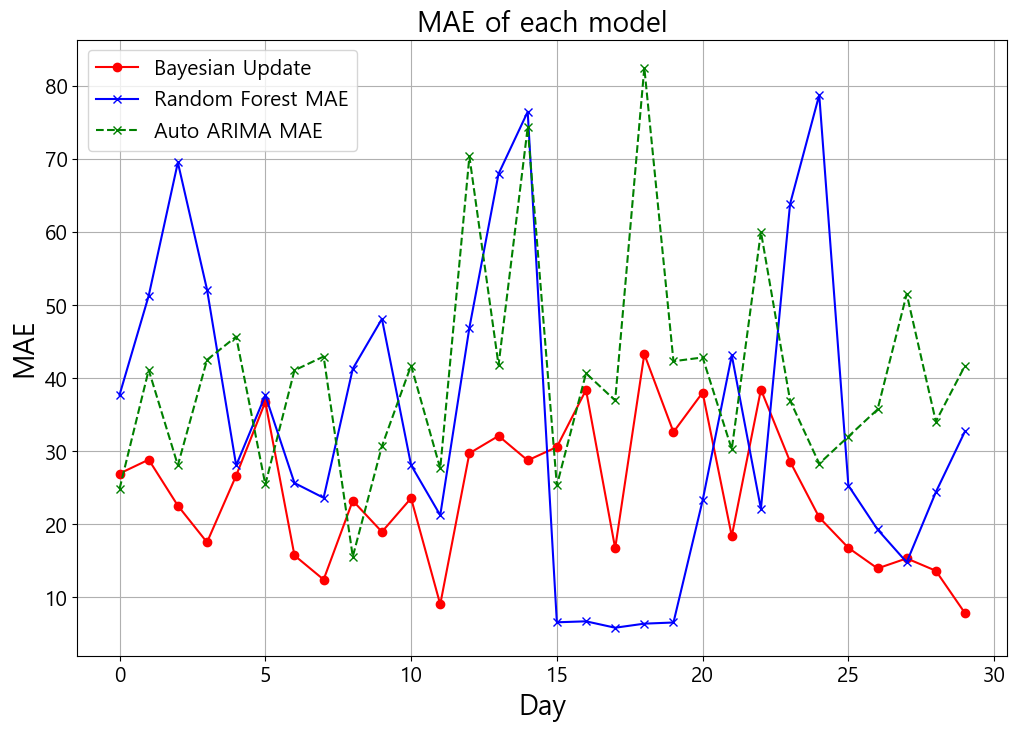

In [69]:
#plt.ylim(0,300)
mae_values = np.array(model_mae)

plt.figure(figsize=(12,8))
plt.plot(pred_error_mae, label = 'Bayesian Update', marker='o', color='red')
plt.plot(mae_values[:, 0], label="Random Forest MAE", marker='x', color='blue', linestyle ='-')
plt.plot(mae_values[:, 1], label="Auto ARIMA MAE", marker='x', color='green', linestyle='--')
plt.legend(fontsize = 15)
plt.ylabel('MAE', fontsize = 20)
plt.xlabel('Day', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('MAE of each model', fontsize = 20)
plt.grid()
plt.show()